In [5]:
import numpy as np
import pandas as pd
import lightgbm as lgb
def add_bp_class(df, sbp_col="sbp", dbp_col="dbp", new_col="bp_class"):
    """
    Add blood pressure class column based on SBP and DBP values.
    
    Categories:
        0: sbp < 120 and dbp < 80
        1: 120 <= sbp < 140 or 80 <= dbp < 90
        2: sbp >= 140 or dbp >= 90
    """
    
    conditions = [
        (df[sbp_col] < 120) & (df[dbp_col] < 80),
        ((df[sbp_col] >= 120) & (df[sbp_col] < 140)) | ((df[dbp_col] >= 80) & (df[dbp_col] < 90)),
        (df[sbp_col] >= 140) | (df[dbp_col] >= 90)
    ]
    
    values = [0, 1, 2]
    
    df[new_col] = np.select(conditions, values, default=np.nan).astype(int)
    return df


def add_sbp_class(df, col_name='sbp', new_col='sbp_class'):
    """
    SBP値に応じてクラスを付与する関数
      - sbp < 100 → 0
      - 100 <= sbp < 140 → 1
      - sbp >= 140 → 2

    Parameters
    ----------
    df : pd.DataFrame
        SBP列を含むデータフレーム
    col_name : str, default 'sbp'
        SBPの列名
    new_col : str, default 'sbp_class'
        新しい列名

    Returns
    -------
    df : pd.DataFrame
        新しい列が追加されたDataFrame
    """
    conditions = [
        df[col_name] < 100,
        (df[col_name] >= 100) & (df[col_name] < 140),
        df[col_name] >= 140
    ]
    values = [0, 1, 2]
    df[new_col] = np.select(conditions, values).astype('int')
    return df

def add_sbp_class_2(df, col_name='sbp',boundary=120, new_col='sbp_class'):
    """
    SBP値に応じてクラスを付与する関数
      - sbp < boundary → 0
      - sbp >= boundary → 2

    Parameters
    ----------
    df : pd.DataFrame
        SBP列を含むデータフレーム
    col_name : str, default 'sbp'
        SBPの列名
    new_col : str, default 'sbp_class'
        新しい列名

    Returns
    -------
    df : pd.DataFrame
        新しい列が追加されたDataFrame
    """
    conditions = [
        df[col_name] < boundary,
        df[col_name] >= boundary
    ]
    values = [0, 2]
    df[new_col] = np.select(conditions, values).astype('int')
    return df
from sklearn.model_selection import StratifiedGroupKFold
def get_groupkf(df,k=5, group_col='subject',y_col='sbp_class', random_state=42,get_holdout=False):
    """
    StratifiedGroupKFoldを用いてデータを分割する関数
    Parameters
    ----------
    df : pd.DataFrame
        分割対象のデータフレーム
    k : int, default 5
        分割数
    group_col : str, default 'subject'
        グループ化に使用する列名
    y_col : str, default 'sbp_class'
        ラベル列名 
    random_state : int, default 42
        乱数シード
    get_holdout : bool, default False
        ホールドアウトセットを取得するかどうか
    Returns
    -------
    folds : list of tuples
        各フォールドのデータセットのリスト
        get_holdoutがTrueの場合、各タプルは(train_data, val_data, hold_data)となる
        get_holdoutがFalseの場合、各タプルは(train_data, hold_data)となる
    """
    gkf = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=random_state)
    gkf2 = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=random_state)
    folds = []
    for use_idx, hold_idx in gkf.split(df,df[y_col], groups=df[group_col]):
        u = df.iloc[use_idx]
        h = df.iloc[hold_idx]
        if get_holdout:
            for train_idx, val_idx in gkf2.split(u,u[y_col], groups=u[group_col]):
                t = u.iloc[train_idx]
                v = u.iloc[val_idx]
                break
            print(set(t[group_col]) & set(v[group_col])& set(h[group_col]))
            train_data = get_dataset(t, weight='balanced',y_col=y_col)
            val_data = get_dataset(v,return_raw=True)
        else:
            print(set(u[group_col]) & set(h[group_col]))
            train_data = get_dataset(u, weight='balanced',y_col=y_col)
        hold_data = get_dataset(h,return_raw=True,y_col=y_col)
        if get_holdout:
            folds.append((train_data, val_data, hold_data))
        else:
            folds.append((train_data, hold_data))
    return folds
def get_dataset(df,weight=None,return_raw=False,y_col='sbp_class'):
    """
    Daframeから不要な列を除いてLightGBM用のデータセットを作成する関数
    Parameters
    ----------
    df : pd.DataFrame
        特徴量とラベルを含むデータフレーム

    weight : str or None, default None
        クラス重みの指定。Noneの場合は重みなし、'balanced'の場合はバランス調整された重みを使用。
    Returns
    -------
    dataset : lgb.Dataset
        LightGBM用のデータセット
    """ 
    X = df.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class','sbp_bin',"bp_class"],axis=1, errors='ignore')
    Y = df[y_col]
    if weight is not None:
        weights = compute_sample_weight(class_weight=weight, y=Y)
        dataset = lgb.Dataset(X, label=Y, weight=weights)
        return dataset
    dataset = lgb.Dataset(X, label=Y)
    if return_raw:
        return [X, Y] 
    return dataset
    
def add_class(classes=3, boundary=120):
    train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features.parquet')
    # test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
    test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  

    train_df=train_df.drop('Unnamed: 0', axis=1, errors='ignore')
    test_df=test_df.drop('Unnamed: 0', axis=1, errors='ignore')  
    if boundary is None:
        # print("1",boundary)
        train_df = add_sbp_class(train_df)
        test_df = add_sbp_class(test_df)
        print(test_df["sbp_class"].nunique())
    else:
        # print("2",boundary,classes)
        train_df = add_sbp_class_2(train_df, boundary=boundary)
        test_df = add_sbp_class_2(test_df, boundary=boundary)
    if classes==2:
        # print("2",boundary,classes)
        train_df = train_df[train_df['sbp_class'] != 1]
        test_df = test_df[test_df['sbp_class'] != 1]
        train_df['sbp_class'] = train_df['sbp_class'] // 2 
        test_df['sbp_class'] = test_df['sbp_class'] // 2
    return train_df, test_df

In [20]:
train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features.parquet')
# test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
# train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_train_all.parquet')
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
train_df=train_df.drop('Unnamed: 0', axis=1, errors='ignore')
test_df=test_df.drop('Unnamed: 0', axis=1, errors='ignore')  
train_df.shape, test_df.shape

((448377, 103), (90289, 102))

In [21]:
train_df["subject"].nunique(), test_df["subject"].nunique()

(2486, 275)

In [8]:
train_df = add_bp_class(train_df)
test_df = add_bp_class(test_df)
train_X,train_Y = get_dataset(train_df, return_raw=True, y_col='bp_class')
# folds = get_groupkf(train_df, k=5, group_col='subject', y_col='bp_class', random_state=42)
test_X,test_Y = get_dataset(test_df, return_raw=True, y_col='bp_class')
print(train_X.shape, test_X.shape)

(448377, 98) (90289, 98)


In [ ]:
53       SQI_skew  114254.667671
10  TSystoDiaRise   76054.369681
59          apg_e   62740.107519
23      DW25_norm   48979.225268
81       T_d_norm   40291.617695
74            T_b   38508.331985
75            T_c   32210.656595
77            T_e   28138.203801
87       T_peak_e   25045.124851
9    SteepDiaRise

In [19]:
train_df.columns.tolist()

['Tc',
 'Ts',
 'Td',
 'Tsteepest',
 'Steepest',
 'TNegSteepest',
 'NegSteepest',
 'TdiaRise',
 'DiaRise',
 'SteepDiaRise',
 'TSystoDiaRise',
 'TdiaToEnd',
 'Ratio',
 'Ts_norm',
 'Td_norm',
 'Tsteepest_norm',
 'TNegSteepest_norm',
 'TdiaRise_norm',
 'TSystoDiaRise_norm',
 'TdiaToEnd_norm',
 'SW25',
 'SW25_norm',
 'DW25',
 'DW25_norm',
 'SWaddDW25',
 'SWaddDW25_norm',
 'DWdivSW25',
 'SW50',
 'SW50_norm',
 'DW50',
 'DW50_norm',
 'SWaddDW50',
 'SWaddDW50_norm',
 'DWdivSW50',
 'SW75',
 'SW75_norm',
 'DW75',
 'DW75_norm',
 'SWaddDW75',
 'SWaddDW75_norm',
 'DWdivSW75',
 'S1',
 'S2',
 'S3',
 'S4',
 'AUCsys',
 'AUCdia',
 'S1_norm',
 'S2_norm',
 'S3_norm',
 'S4_norm',
 'AUCsys_norm',
 'AUCdia_norm',
 'SQI_skew',
 'SQI_kurtosis',
 'apg_a',
 'apg_b',
 'apg_c',
 'apg_d',
 'apg_e',
 'ppg_a',
 'ppg_b',
 'ppg_c',
 'ppg_d',
 'ppg_e',
 'ratio_apg_b',
 'ratio_apg_c',
 'ratio_apg_d',
 'ratio_apg_e',
 'ratio_ppg_b',
 'ratio_ppg_c',
 'ratio_ppg_d',
 'ratio_ppg_e',
 'T_a',
 'T_b',
 'T_c',
 'T_d',
 'T_e',
 'T

In [9]:
import umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP()
selected_cols = ["SQI_skew","TSystoDiaRise","apg_e","DW25_norm","T_d_norm","T_b","T_c","T_e","T_peak_e","SteepDiaRise"]
train_X = train_X[selected_cols]
test_X = test_X[selected_cols]
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
train_X.shape, test_X.shape

((448377, 10), (90289, 10))

In [10]:
embeddings = reducer.fit_transform(train_X)

In [13]:
embeddings.shape

(448377, 2)

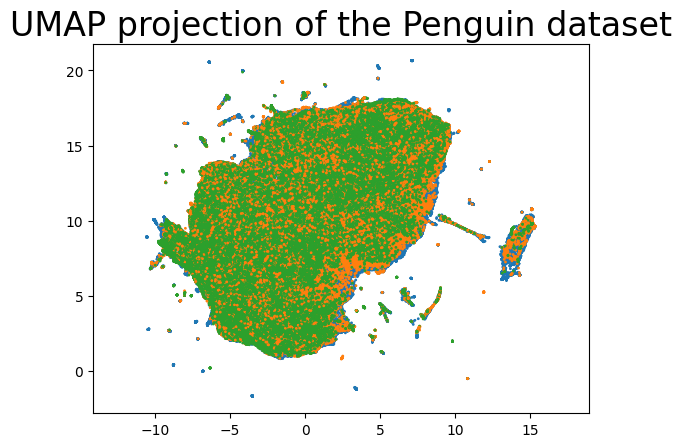

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=[sns.color_palette()[x] for x in train_Y],
    s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);